# Recurrent Neural Networks

### Practical Session

<br/> Prof. Dr. Georgios K. Ouzounis
<br/> email: georgios.ouzounis@go.kauko.lt

<br/> Student Tomas Radžiūnas
<br/> email: tomas.ra9418@go.kauko.lt

## Contents

1. Data loading and pre-processing
2. Building the RNN
3. Train and deploy the RNN
4. Improving the RNN

Using a 10-year history of the Microsoft Stock prices, we are going to predict the stock values for the most recent month that is not included in the historical data.

## Data loading and pre-processing

### Download the data-sets

The data-sets are two comma-separated values files (CSV) and contain a data table of 2538 records for training and a table of 22 records for testing.

We download these from finance.yahoo.com and then upload them to our github repository.

**Microsoft_Stock_Price_Test.csv** and **Microsoft_Stock_Price_Train.csv**

We then download them using the wget command in the terminal

```shell
wget https://raw.githubusercontent.com/Eimantas1337/assignment/main/Microsoft_Stock_Price_Test.csv

wget https://raw.githubusercontent.com/Eimantas1337/assignment/main/Microsoft_Stock_Price_Train.csv
```

### Import libraries

We need 3 main libraries:

- [Numpy](http://www.numpy.org): it is the fundamental package for scientific computing with Python. It contains among other things a powerful N-dimensional array object that can be used as an efficient multi-dimensional container of generic data. Arbitrary data-types can be defined.
- [matplotlib](https://matplotlib.org):  it is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.
- [pandas](https://pandas.pydata.org): is a software library written for the Python programming language for data manipulation and analysis. In particular, it offers data structures and operations for manipulating numerical tables and time series.

In [1]:
# importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Import the dataset

We load the relevant files containing 10 years of stock prices of Microsoft from 2009 to 2019.


In [2]:
#importing the dataset

# load the training file contents 
dataset_train = pd.read_csv('Microsoft_Stock_Price_Train.csv')

In [3]:
dataset_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-07-01,24.049999,24.299999,23.959999,24.040001,18.585423,54908400
1,2009-07-02,23.760000,24.040001,23.209999,23.370001,18.067444,65422200
2,2009-07-06,23.209999,23.280001,22.870001,23.200001,17.936018,49207700
3,2009-07-07,23.080000,23.139999,22.459999,22.530001,17.418032,52842500
4,2009-07-08,22.309999,22.690001,22.000000,22.559999,17.441227,73023400


In [4]:
# Create a subtable of relevant entries (open values)
# The .values makes this vector a numpy array
training_set = dataset_train.iloc[:, 1:2].values 

In [5]:
training_set

array([[ 24.049999],
       [ 23.76    ],
       [ 23.209999],
       ...,
       [140.369995],
       [141.5     ],
       [140.139999]])

### Feature Scaling

Next we need to rescale our data to the range from 0 to 1. 

Feature scaling is essential as discussed if the Features lecture and needs to be applied to both the training and test sets.

It is computed using the ScikitLearn library [MinMaxScaler()](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) which transforms the selected feature by scaling it to a given range. If more than one, this estimator scales and translates each feature individually such that it is in the given range on the training set, i.e. between zero and one.

In [6]:
# Feature Scaling

# import the MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

In [7]:
# create a scaler instance to rescale all data to the range of 0.0 to 1.0 
sc = MinMaxScaler(feature_range = (0, 1))

In [8]:
# create the actual training set of scaled values
training_set_scaled = sc.fit_transform(training_set)

In [9]:
training_set_scaled

array([[0.01558962],
       [0.01315899],
       [0.00854914],
       ...,
       [0.99052883],
       [1.        ],
       [0.98860111]])

### Splitting the training set to dependent and independent variables

In [10]:
# Creating a data structure with 90 timesteps and 1 output

# the 90 stock prices in the last 3 months before today
X_train = [] 

In [11]:
training_set_scaled.shape

(2537, 1)

In [12]:
# the stock price today
y_train = [] 

In [13]:
# we start from day 90 because that is the first instance allowing us to 
# go back 90 days. we also change the range to 2537, because we have 2537 records in our 10 year dataset
for i in range(90, 2537): 
    # 0 is the column ID, the only column in this case.    
    # put the last 90 days values in one row of X_train
    X_train.append(training_set_scaled[i-90:i, 0]) 
    y_train.append(training_set_scaled[i, 0])


In [14]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [15]:
X_train

array([[0.01558962, 0.01315899, 0.00854914, ..., 0.04567931, 0.0460984 ,
        0.05305506],
       [0.01315899, 0.00854914, 0.00745955, ..., 0.0460984 , 0.05305506,
        0.05188164],
       [0.00854914, 0.00745955, 0.00100577, ..., 0.05305506, 0.05188164,
        0.05389322],
       ...,
       [0.80378842, 0.79792137, 0.79582599, ..., 0.9854161 , 0.97820798,
        0.99103171],
       [0.79792137, 0.79582599, 0.8156064 , ..., 0.97820798, 0.99103171,
        0.99052883],
       [0.79582599, 0.8156064 , 0.7909647 , ..., 0.99103171, 0.99052883,
        1.        ]])

### Reshaping the Matrix

We need to add a new matrix dimension to accommodate the indicator (predictor). 

NumPy matrices are tensors (3D) and essentially we need to specify that our matrix consists of **90 days** (dimension x) times **total days in data set** (dimension y) times **1 value per matrix cell (scalar)** (dimension z)

In [16]:
# Reshaping the data matrix, we retain the 2 original dimensions and add a third of depth=1
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Building the RNN

### Downloading keras and initializing the RNN

We put <b>pip3 install keras</b> in our terminal to download keras for this task.

Using Keras, that we installed earlier, we are going to import the sequential model, dense layer template and the LTSM model from the Keras API and we are going to create an instance of the sequential model called regressor because we want to predict a continious value.

In [17]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [18]:
# Initialising the RNN as a sequence of layers
regressor = Sequential()

### Add First Layer

We first add an object of the LSTM class! 

- The first argument is the number of units or LSTM memory cells. Include many neurons to address the high dimensionality of the problem; say 50 neurons! 
- Second arg: return sequences = true; stacked LSTM !
- Third arg: input 3D shape: observations vs time steps vs number of indicators

In [19]:
# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape =  (X_train.shape[1], 1)))

In [20]:
# the argument is the dropout rate to ignore in the layers (20%), 
# i.e. 50 units * 20% = 10 units will be dropped each time
regressor.add(Dropout(0.2))


### Add More Layers

We can add more LSTM layers but along with Dropout regularization to make sure we avoid overfitting! 

We don’t need to add the shape of the layer again because it is recognized automatically from the number of input units.

The last layer does not return a sequence but connected directly to a fully connected output layer.


In [21]:
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [22]:
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [23]:
# Adding a fourth LSTM layer and some Dropout regularisation
# we removed the return_sequences because we no longer return a 
# sequence but a value instead
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

### Add Output Layer & Compile

The output has 1 dimension , i.e. one value to be predicted thus or output fully connected layer has dimensionality = 1.

- **Optimizer**: rmsprop is recommended in the Keras documentation. The Adam optimizer is also a powerful choice.
- **Loss function**: regression problems take the mean square error as most common

In [24]:
# Adding the output layer
regressor.add(Dense(units = 1))

In [25]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Train and deploy the RNN

### Fit the RNN to the Training set

Now we train our RNN using the data in our training set and ground truth. We also have a couple of parameters that we could specify:

- **Batch size**:  update the cell weights not on every stock price on every batch_size values; 
- **Number of epochs**: how many iterations to be used, i.e. number of forward and backward propagations for the update of the weights


In [26]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
77/77 [==============================] - 10s 130ms/step - loss: 0.0092
Epoch 2/100
77/77 [==============================] - 10s 127ms/step - loss: 0.0017
Epoch 3/100
77/77 [==============================] - 10s 126ms/step - loss: 0.0016
Epoch 4/100
77/77 [==============================] - 10s 126ms/step - loss: 0.0013
Epoch 5/100
77/77 [==============================] - 10s 125ms/step - loss: 0.0012
Epoch 6/100
77/77 [==============================] - 10s 125ms/step - loss: 0.0017
Epoch 7/100
77/77 [==============================] - 10s 124ms/step - loss: 0.0015
Epoch 8/100
77/77 [==============================] - 10s 125ms/step - loss: 0.0011
Epoch 9/100
77/77 [==============================] - 10s 125ms/step - loss: 0.0013
Epoch 10/100
77/77 [==============================] - 10s 125ms/step - loss: 0.0012
Epoch 11/100
77/77 [==============================] - 10s 125ms/step - loss: 0.0014
Epoch 12/100
77/77 [==============================] - 10s 125ms/step - loss: 0.0012
E

### Computing Predictions

Now I create a data-frame by impoting the Microsoft Stock Price Test set for August 2019 using pandas and I make it a numpy array.


In [27]:
# Getting the real stock price for July 31st 2009 - 
# July 31st 2019
dataset_test = pd.read_csv('Microsoft_Stock_Price_Test.csv')
dataset_test

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-08-01,137.000000,140.940002,136.929993,138.059998,136.052872,40557500
1,2019-08-02,138.089996,138.320007,135.259995,136.899994,134.909729,30791600
2,2019-08-05,133.300003,133.929993,130.779999,132.210007,130.287949,42749600
3,2019-08-06,133.800003,135.679993,133.210007,134.690002,132.731888,32696700
4,2019-08-07,133.789993,135.649994,131.830002,135.279999,133.313278,33414500
5,2019-08-08,136.600006,138.990005,135.929993,138.889999,136.870834,27496500
6,2019-08-09,138.610001,139.380005,136.460007,137.710007,135.707993,23466700
7,2019-08-12,137.070007,137.860001,135.240005,135.789993,133.815887,20476600
8,2019-08-13,136.050003,138.800003,135.000000,138.600006,136.585052,25154600
9,2019-08-14,136.360001,136.919998,133.669998,133.979996,132.471863,32527300


In [28]:
real_stock_price = dataset_test.iloc[:, 1:2].values
real_stock_price.size

22

In [29]:
real_stock_price

array([[137.      ],
       [138.089996],
       [133.300003],
       [133.800003],
       [133.789993],
       [136.600006],
       [138.610001],
       [137.070007],
       [136.050003],
       [136.360001],
       [134.389999],
       [134.880005],
       [137.850006],
       [138.210007],
       [138.550003],
       [138.660004],
       [137.190002],
       [134.990005],
       [136.389999],
       [134.880005],
       [137.25    ],
       [139.149994]])

In [30]:
# Getting the predicted stock price of 2019

# axis = 0 means concatenate the lines (i.e. vertical axis)
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0) 

In [31]:
dataset_total.size


2559

In [32]:
# the difference in the length of the first two gives us 
# the first day in 2019, and we need to go back 90 days to get the necessary range
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 90:].values

In [33]:
inputs.size

112

In [34]:
# we did not use iloc from panda so lets reshape the numpy array for 
# compatibility: i.e. all the values from input lines to be stacked in one 
# column. The -1 means that the numpy has no knowledge of how the 
# values were stored in lines. The 1 means we want to them in one 
# column.

inputs = inputs.reshape(-1,1) 

# apply the feature scaler
inputs = sc.transform(inputs)

In [35]:
# Getting the predicted stock price of 2019
X_test = []

In [36]:
# the first 90 from inputs are from training set; start 
# from 90 and get the extra 22
for i in range(90, 112): 
    X_test.append(inputs[i-90:i, 0])


In [37]:
X_test = np.array(X_test) # not 3D structure yet

In [38]:
# create a 3D structure
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [39]:
predicted_stock_price = regressor.predict(X_test)

In [40]:
# need to inverse the scaling to get meaningful predicted stock price # outputs
predicted_stock_price = sc.inverse_transform(predicted_stock_price) 
predicted_stock_price.size

22

### Result Visualization


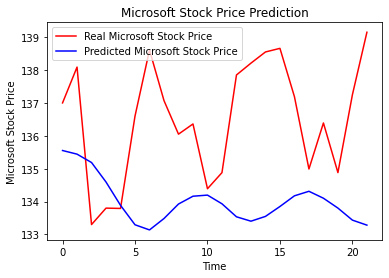

In [42]:
# Visualising the results

plt.plot(real_stock_price, color = 'red', label = 'Real Microsoft Stock Price')

plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Microsoft Stock Price')

plt.title('Microsoft Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Microsoft Stock Price')
plt.legend()

plt.show()

The blue line shows the trend of the stock for the month of August 2019. 

Some observations:
- The prediction is far more smoother than the actual stock price.
- Some fiddling is required to get a smaller relative error.

### Compute the RMSE

If we need to compute the RMSE for our Stock Price Prediction problerm, we use the real stock rpice and predicted stock price as shown.

We can getting a relative error, by dividing this RMSE by the range of the Microsoft Stock Price values of August 2019.

In [43]:
#import the libraries
import math
from sklearn.metrics import mean_squared_error

In [44]:
rmse = math.sqrt( mean_squared_error( real_stock_price[0:22,:], predicted_stock_price))
rmse

3.248572859963501